# import

In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import os

from gensim.models import FastText
from tensorflow import keras
from tensorflow.keras import layers, metrics, callbacks, optimizers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import import_ipynb
from module import Pipeline as pl
from module import korean_tokenizers as kt
from module import Custom_Functions as cf
from module import Word_Embedding

2022-10-25 09:51:31.874961: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


importing Jupyter notebook from /home/faraway/ft_classifier/module/Pipeline.ipynb
importing Jupyter notebook from /home/faraway/ft_classifier/module/korean_tokenizers.ipynb
importing Jupyter notebook from /home/faraway/ft_classifier/module/Custom_Functions.ipynb
importing Jupyter notebook from /home/faraway/ft_classifier/module/Word_Embedding.ipynb


# Global

In [2]:
best_model_path = 'Models/multi_label_improve_best.h5'

custom_tokenizer = kt.word_cjs_tokenizer

# Preprocess

In [3]:
train_data = pd.read_csv("korean_unsmile_dataset/unsmile_train_v1.0.tsv", sep= "\t")
test_data = pd.read_csv("korean_unsmile_dataset/unsmile_valid_v1.0.tsv", sep= "\t")

In [4]:
features = train_data.columns[1:]

In [5]:
X, y = train_data.iloc[:, 0], train_data.iloc[:, 1:]

train_X, valid_X, train_y, valid_y = train_test_split(X, y,
                                                      train_size= 0.8)
test_X, test_y = test_data.iloc[:, 0], test_data.iloc[:, 1:]

In [6]:
tokenized_train_X = pl.tokenization(train_X, custom_tokenizer)
tokenized_valid_X = pl.tokenization(valid_X, custom_tokenizer)
tokenized_test_X = pl.tokenization(test_X, custom_tokenizer)

train_y = train_y.values
valid_y = valid_y.values
test_y = test_y.values

# FastText

In [8]:
ft = FastText(
    sentences = tokenized_train_X,
    vector_size = 100, 
    window = 4, 
    min_count = 3, 
    workers = 2, 
    alpha = 0.1, min_alpha = 0.001, 
    min_n = 1, max_n = 6, 
    sg = 1, 
    epochs= 25)

In [9]:
ft.wv.most_similar('ㅇㅏ')

[('ㅇㅏㄻ', 0.8352296948432922),
 ('ㅇㅏㅁ', 0.7590600848197937),
 ('ㅇㅏㅇ', 0.7423507571220398),
 ('ㅇㅏㄹ', 0.6521777510643005),
 ('ㅇㅏㄶㅇㅏ*', 0.641583263874054),
 ('ㅇㅏㄶㄱㅔ*', 0.6296713352203369),
 ('ㅇㅏㄶㄱㅗ*', 0.627871036529541),
 ('ㅇㅏㄶㅇㅏㅆㄴㅑ*', 0.6210477948188782),
 ('ㅇㅏ*', 0.5998600721359253),
 ('ㅇㅏㄶㅇㅏ*ㅇㅛ*', 0.5994904041290283)]

In [10]:
ft.wv.vectors_vocab.shape

(5113, 100)

In [11]:
tokenizer_tf, embedding_weights = Word_Embedding.make_embedding_models(
                                        tokenized_texts = tokenized_train_X,
                                        fasttext = ft
                                        )

In [12]:
len(tokenizer_tf.word_index)

54155

In [13]:
max_len = 0
for X in tokenized_train_X :
  if len(X) > max_len :
    max_len = len(X)

print(max_len)

MAX_LEN = 250

41


In [14]:
int_train_X = pl.texts_to_int(tokenized_train_X, tokenizer_tf, max_len = MAX_LEN)
int_valid_X = pl.texts_to_int(tokenized_valid_X, tokenizer_tf, max_len = MAX_LEN)
int_test_X = pl.texts_to_int(tokenized_test_X, tokenizer_tf, max_len = MAX_LEN)

int_train_X.shape, int_valid_X.shape, int_test_X.shape

((12004, 250), (3001, 250), (3737, 250))

# Sequential

In [15]:
# BiLSTM
dnn = keras.Sequential([
    layers.Input(shape=(MAX_LEN, )),
    layers.Embedding(len(tokenizer_tf.word_index) + 1, ft.vector_size,
                     weights = [embedding_weights], trainable = False,
                    #  mask_zero= True      # 버전에 따른 이슈 있음
                     ),                     # OP_REQUIRES failed at cudnn_rnn_ops.cc:1517 : Unknown: CUDNN_STATUS_BAD_PARAM
    layers.Masking(mask_value=0),
    layers.Bidirectional(layers.LSTM(units = ft.vector_size, return_sequences=True)),
    layers.Conv1D(ft.vector_size, 4, activation = 'relu', padding = "same"),
    layers.Dropout(0.5),
    layers.Bidirectional(layers.LSTM(units = ft.vector_size, return_sequences=False)),
    layers.Dense(len(features), activation = 'sigmoid')
])

dnn.summary()

dnn.compile(
    loss = cf.focal_loss(),     # 버전에 따라 tf.keras.losses.BinaryFocalCrossentropy()
    optimizer = optimizers.Nadam(), 
    metrics = [ metrics.Recall(thresholds = 0.5), metrics.Precision(thresholds = 0.5), cf.f1_score, "acc"]
    )

2022-10-25 09:51:47.549758: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-10-25 09:51:47.594630: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:968] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-25 09:51:47.594676: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 Ti computeCapability: 7.5
coreClock: 1.485GHz coreCount: 16 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 178.84GiB/s
2022-10-25 09:51:47.594701: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-10-25 09:51:47.596394: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-10-25 09:51:47.597743: I tensorflow/stream_exec

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5415600   
_________________________________________________________________
masking (Masking)            (None, 250, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 250, 200)          160800    
_________________________________________________________________
conv1d (Conv1D)              (None, 250, 100)          80100     
_________________________________________________________________
dropout (Dropout)            (None, 250, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense (Dense)                (None, 11)                2

In [16]:
# Keras 모델 콜백
cp = callbacks.ModelCheckpoint(best_model_path,             # file명을 지정합니다
                               monitor='val_f1_score',   # val_f1_score 값이 개선되었을때 호출됩니다
                               verbose=1,            # 로그를 출력합니다
                               save_best_only=True,  # 가장 best 값만 저장합니다
                               mode='max'           # auto는 알아서 best를 찾습니다. min/max
                               )
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

callback_list = [cp, es]

history = dnn.fit(int_train_X, train_y,
                  epochs=100, 
                  validation_data=(int_valid_X, valid_y),
                  batch_size = 128, 
                  callbacks = callback_list)

Epoch 1/100


2022-10-25 09:52:02.344058: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-10-25 09:52:03.225756: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7


94/94 [==============================] - ETA: 0s - loss: 0.0296 - recall: 0.0047 - precision: 0.0945 - f1_score: 0.0024 - acc: 0.2811
Epoch 00001: val_f1_score improved from -inf to 0.01104, saving model to Models/multi_label_improve_best.h5
94/94 [==============================] - 28s 293ms/step - loss: 0.0296 - recall: 0.0047 - precision: 0.0945 - f1_score: 0.0024 - acc: 0.2811 - val_loss: 0.0273 - val_recall: 0.0058 - val_precision: 0.7308 - val_f1_score: 0.0110 - val_acc: 0.3436
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: 0.0232 - recall: 0.0666 - precision: 0.8543 - f1_score: 0.1205 - acc: 0.4509
Epoch 00002: val_f1_score improved from 0.01104 to 0.14281, saving model to Models/multi_label_improve_best.h5
94/94 [==============================] - 24s 253ms/step - loss: 0.0232 - recall: 0.0666 - precision: 0.8543 - f1_score: 0.1205 - acc: 0.4509 - val_loss: 0.0264 - val_recall: 0.0787 - val_precision: 0.7808 - val_f1_score: 0.1428 - val_acc: 0.4155
Epoch 3/1

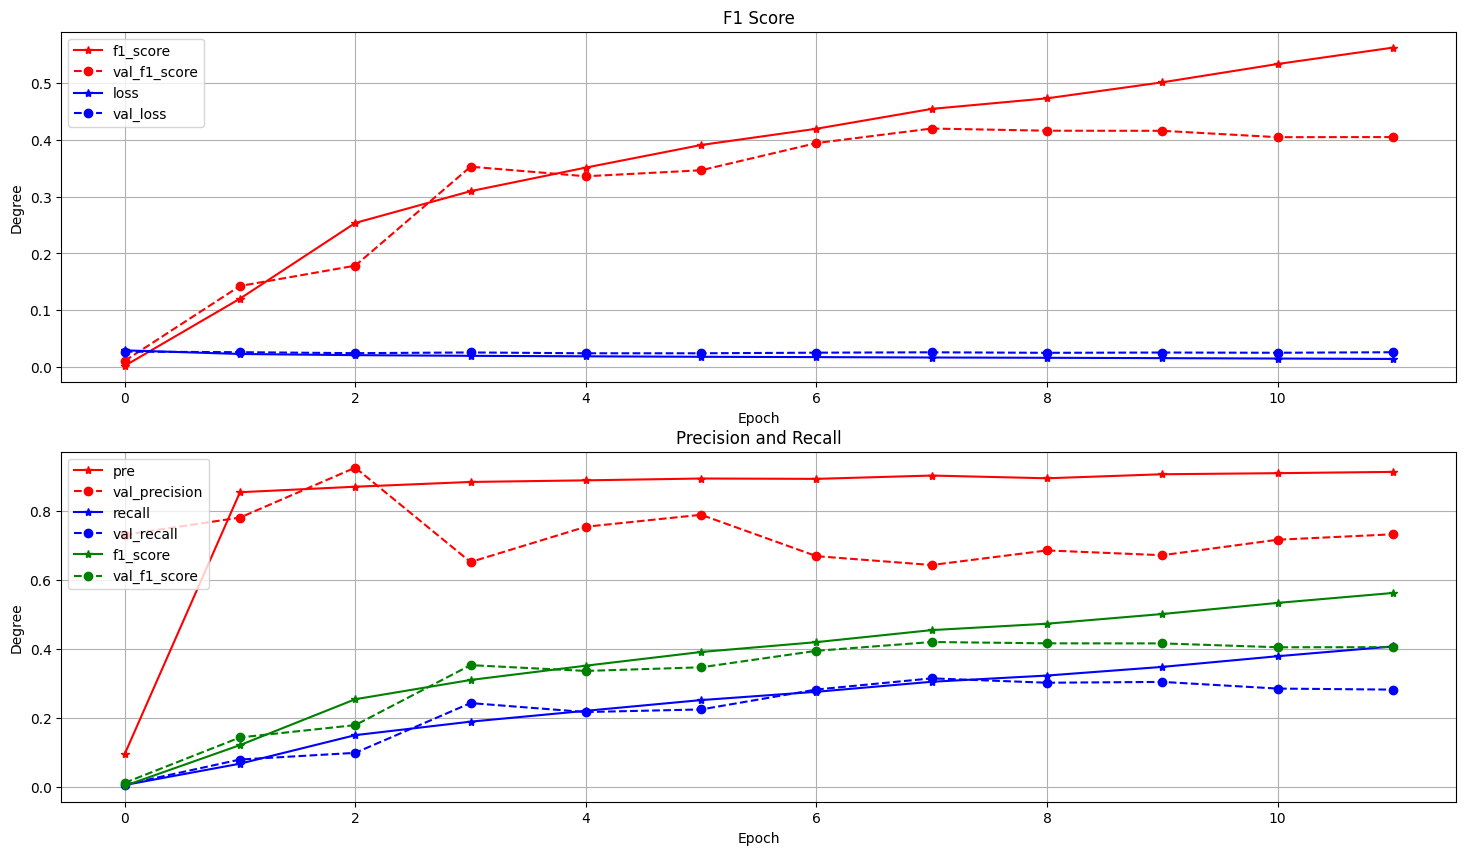

In [17]:
plt.figure(figsize = (18, 10))

plt.subplot(211)
plt.plot(history.history['f1_score'], color = 'red', marker = '*')
plt.plot(history.history['val_f1_score'], color = 'red', linestyle = '--', marker = 'o')
plt.plot(history.history['loss'], color = 'blue', marker = '*')
plt.plot(history.history['val_loss'], color = 'blue', linestyle = '--', marker = 'o')

plt.grid(True)
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Degree')
plt.legend(['f1_score', 'val_f1_score', 'loss', 'val_loss'], loc='upper left')

plt.subplot(212)
plt.plot(history.history['precision'], color = 'red', marker = '*')
plt.plot(history.history['val_precision'], color = 'red', linestyle = '--', marker = 'o')
plt.plot(history.history['recall'], color = 'blue', marker = '*')
plt.plot(history.history['val_recall'], color = 'blue', linestyle = '--', marker = 'o')
plt.plot(history.history['f1_score'], color = 'green', marker = '*')
plt.plot(history.history['val_f1_score'], color = 'green', linestyle = '--', marker = 'o')

plt.grid(True)
plt.title('Precision and Recall')
plt.xlabel('Epoch')
plt.ylabel('Degree')
plt.legend(['pre', 'val_precision', 'recall', 'val_recall', "f1_score", "val_f1_score"], loc='upper left')

plt.show()

In [18]:
model = keras.models.load_model(best_model_path, 
                                     custom_objects={
                                         'focal_loss_fixed': cf.focal_loss(), 
                                         'f1_score' : cf.f1_score
                                         }
                                     )

model.evaluate(int_test_X, test_y)

117/117 [==============================] - 6s 54ms/step - loss: 0.0253 - recall: 0.3227 - precision: 0.6437 - f1_score: 0.4272 - acc: 0.5020


[0.025323230773210526,
 0.3227396011352539,
 0.6437346339225769,
 0.4271968603134155,
 0.5020069479942322]

In [26]:
predict = model.predict(int_test_X)
pred_with_threshold = np.where(predict > 0.3, 1, 0)   # 예상치가 0.4를 넘으면 1, 아니면 0

print(classification_report(test_y, pred_with_threshold,
                            target_names= features))

              precision    recall  f1-score   support

       여성/가족       0.73      0.39      0.51       394
          남성       0.70      0.52      0.60       334
        성소수자       0.78      0.56      0.66       280
       인종/국적       0.59      0.48      0.53       426
          연령       0.85      0.34      0.49       146
          지역       0.75      0.46      0.57       260
          종교       0.79      0.60      0.68       290
       기타 혐오       0.24      0.07      0.11       134
       악플/욕설       0.37      0.52      0.43       786
       clean       0.36      0.94      0.52       935
        개인지칭       0.00      0.00      0.00        74

   micro avg       0.46      0.57      0.51      4059
   macro avg       0.56      0.44      0.46      4059
weighted avg       0.54      0.57      0.51      4059
 samples avg       0.50      0.59      0.53      4059



/home/faraway/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/faraway/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
